#  Naive discriminative learning applied to Spellman's (1996) example

## Preliminary steps

We need to import the necessary libraries and functions. Don't forget to modify your working directory to match where you cloned Github repository

In [67]:
### Import necessary packages
import os
import csv
import re
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings

### Set working directory (MODIFY IT TO MATCH YOUR DIRECTORY!!)
WD = '/media/adnane/HDD drive/Adnane/Teaching/Tutorials_ooominds/DTM_tutorial/'
os.chdir(WD)

### Import local packages (DTM)
import deep_text_modelling.preprocessing as pr
import deep_text_modelling.modelling as md
import deep_text_modelling.evaluation as ev

# Display option for dataframes and matplotlib
warnings.filterwarnings('ignore') # Hide warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', 100) # Max width of columns when displaying a dataframe
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
%matplotlib inline

## Data preparation

We are ready to read the table (formated as `csv` - comma separated values) and show the first few lines:

In [6]:
tomato = pd.read_csv('./Data/spellman.csv')
tomato.head()

,cues,outcomes
0,pot,NO.TOMATO
1,pot_red_blue,TOMATO
2,pot_red,TOMATO
3,pot_red,NO.TOMATO
4,pot_blue,TOMATO


- rows $\rightarrow$ learning events
- columns $\rightarrow$
    + Cues : input units
    + Outcomes : output units (a.k.a., targets or teachers or criteria)

In the implementation of the **Naive Discrimination Learning** (NDL), we often use some *special characters*:

- `_`, separates the items
- `#`, if we are dealing with continuous text, we use hashtags to mark the begining and the end of an item (usually a word)

Thus, from the above table, we can see that in the 2nd learning trial, all three possible cues are present.

Let's see how many learning events (trials), and how many input units (cues) and output units (outcomes) we have :

In [72]:
# First, extract the cues part of all events as a list of lists
cues_ll = tomato['cues'].apply(lambda s: s.split("_")).tolist()
cues_ll

[['pot'],
 ['pot', 'red', 'blue'],
 ['pot', 'red'],
 ['pot', 'red'],
 ['pot', 'blue'],
 ['pot', 'blue'],
 ['pot', 'red'],
 ['pot', 'blue'],
 ['pot', 'red'],
 ['pot', 'red'],
 ['pot', 'red', 'blue'],
 ['pot', 'blue'],
 ['pot', 'red', 'blue'],
 ['pot', 'blue'],
 ['pot', 'red'],
 ['pot', 'blue'],
 ['pot', 'red'],
 ['pot', 'blue'],
 ['pot'],
 ['pot', 'blue']]

In [73]:
# Second, extract the set of unique cues 
cues = set(itertools.chain(*cues_ll))
cues

{'blue', 'pot', 'red'}

In [31]:
# Extract the set of unique cues outcomes
outcomes = set(tomato['outcomes'].tolist())

print(f'- Number of events: {len(tomato)}')
print(f'- Number of cues: {len(cues)}')
print(f'- Number of outcomes: {len(outcomes)}')
print(f'- The cues are: {cues}')
print(f'- The outcomes are: {outcomes}')

- Number of events: 20
- Number of cues: 3
- Number of outcomes: 2
- The cues are: {'red', 'blue', 'pot'}
- The outcomes are: {'NO.TOMATO', 'TOMATO'}


## The training

Now, we are ready to start our training. 

In [71]:
### Build a simple NDL
p = {'epochs': 1, # number of iterations through the full set 
    'lr': 0.01 # learning rate
    }

# Model fitting
NDL_history_dict, NDL_model = md.train(model = 'NDL',
                                       data_train = tomato, 
                                       data_valid = tomato,  
                                       cue_index = None, 
                                       outcome_index = None, 
                                       params = p)

We can display the learned association weights between cues and outcomes:

In [60]:
weight_matrix = np.transpose(NDL_model.weights.values)
weight_matrix

array([[0.08070849, 0.09287923],
       [0.0159678 , 0.07145281],
       [0.04399349, 0.0494923 ]])

In [61]:
all_cues = NDL_model.weights.cues.values.tolist()
all_outcomes = NDL_model.weights.outcomes.values.tolist()

In [62]:
pd.DataFrame(weight_matrix, index=all_cues, columns=all_outcomes)

,NO.TOMATO,TOMATO
pot,0.080708,0.092879
red,0.015968,0.071453
blue,0.043993,0.049492


### Train over multiple epochs

Now let's train the model for longer by going through the data 10 times

In [68]:
### Build a simple NDL
p = {'epochs': 10, # number of iterations through the full set 
    'lr': 0.01 # learning rate
    }

# Model fitting
NDL_history_dict, NDL_model = md.train(model = 'NDL',
                                       data_train = tomato, 
                                       data_valid = tomato,  
                                       cue_index = None, 
                                       outcome_index = None, 
                                       params = p)

The new weight matrix is given by:

In [69]:
weight_matrix = np.transpose(NDL_model.weights.values)
all_cues = NDL_model.weights.cues.values.tolist()
all_outcomes = NDL_model.weights.outcomes.values.tolist()
pd.DataFrame(weight_matrix, index=all_cues, columns=all_outcomes)

,NO.TOMATO,TOMATO
pot,0.343185,0.296085
red,-0.050467,0.325693
blue,0.141356,0.149415


Th following function allow you to assess the learning by displaying what we call the learning curve. It's basically the evolution of a performance measure across the epochs

No handles with labels found to put in legend.


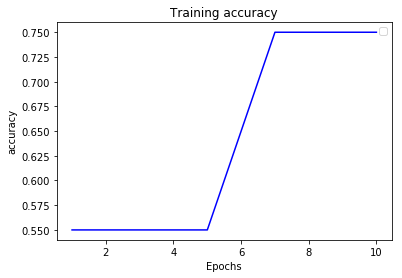

In [70]:
# Generate learning curve
ev.plot_learning_curve(history_dict = NDL_history_dict, metric = 'accuracy', set = 'train')

Notice that the discrimination bewteen the cues only really happened after the 5th epoch. The amount of data that a model encounters determines its performance, and basically the 'epoch' parameter allows you to adjust that amount. 